# Discretizing the sphere

The goal of discretisation is to enable us to learn a function on a sphere equivariant to SO(3) action.
* Consider learning with no rotation
* By hand data augmented rotations
* Invariant model

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import numpy as np
from scipy.spatial.transform import Rotation as R

# Rotation matricies

A basis for a subgroup of SO(3)

In [2]:
def rotate_x(angle):
    """Rotation matrix for rotating around the X-axis."""
    return np.array([
        [1, 0, 0],
        [0, np.cos(angle), -np.sin(angle)],
        [0, np.sin(angle), np.cos(angle)]
    ])
def rotate_y(angle):
    """Rotation matrix for rotating around the Y-axis."""
    return np.array([
        [np.cos(angle), 0, np.sin(angle)],
        [0, 1, 0],
        [-np.sin(angle), 0, np.cos(angle)]
    ])
def rotate_z(angle):
    """Rotation matrix about z axis"""
    return np.array([
        [np.cos(angle), -np.sin(angle),0],
        [np.sin(angle), np.cos(angle),0],
        [0,0,1]
        ])


# Spherical coordinates discretisation

If all permutations of rotations considered we obtain too many points and ridiculous time complexity

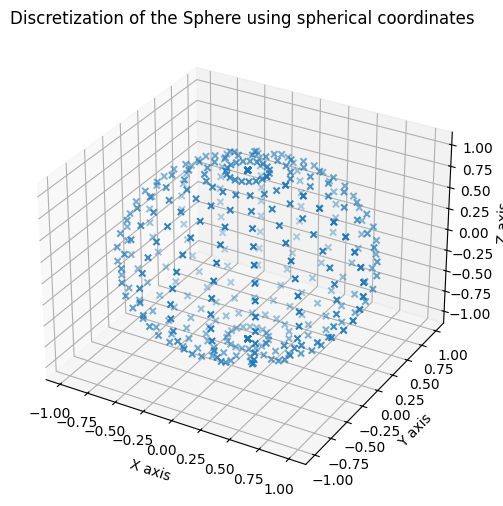

In [3]:
n_alpha = 20
n_beta = 20
n_gamma = 20
alpha = np.linspace(0,2*np.pi,n_alpha)
beta = np.linspace(0,np.pi,n_beta)
# gamma = np.linspace(0,np.pi*2,n_gamma)
alpha_grid, beta_grid = np.meshgrid(alpha,beta)

x = np.sin(beta_grid) * np.cos(alpha_grid)
y = np.sin(beta_grid) * np.sin(alpha_grid)
z = np.cos(beta_grid)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,marker='x')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('Discretization of the Sphere using spherical coordinates')

plt.show()

Problems: rotated sphere is not onto, interpolation required for most rotations

# ZYZ-Euler discretisation

alpha, beta and gamma describe an SO(3) rotation

In [60]:
# Number of steps for each angle edit to see various discretisations
# n_alpha = 100
# n_beta = 50
# n_gamma = 4
n_alpha = 8
n_beta = 80
n_gamma = 8
# n_alpha = 20
# n_beta = 20
# n_gamma = 8

alpha = np.linspace(0, 2* np.pi, n_alpha)
beta = np.linspace(0, np.pi, n_beta)
gamma = np.linspace(0, 2* np.pi, n_gamma)

alpha_grid, beta_grid, gamma_grid = np.meshgrid(alpha, beta, gamma, indexing='ij')

initial_point = np.array([1, 0, 0])

alpha_flat, beta_flat, gamma_flat = alpha_grid.flatten(), beta_grid.flatten(), gamma_grid.flatten()

rotated_points = np.array([
    rotate_z(g) @ rotate_y(b) @ rotate_z(a) @ initial_point 
    for a, b, g in zip(alpha_flat, beta_flat, gamma_flat)
])

rotated_points = rotated_points.reshape(n_alpha, n_beta, n_gamma, 3)

rotated_points.shape



(8, 80, 8, 3)

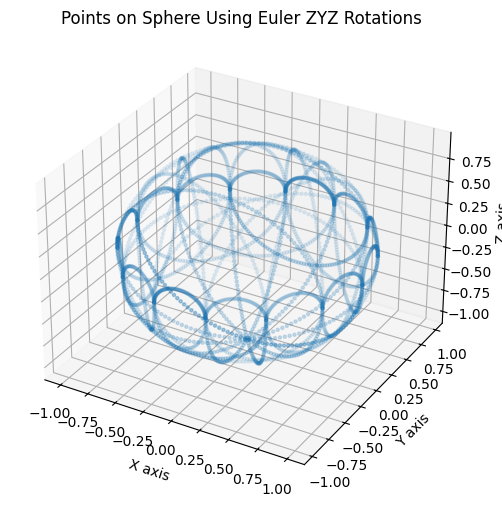

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Flatten the points for plotting
x, y, z = rotated_points.reshape(-1, 3).T

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, alpha=0.1,marker='.')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('Points on Sphere Using Euler ZYZ Rotations')

plt.show()


# Fiboncacci lattice

More uniform but less rotational symmetry

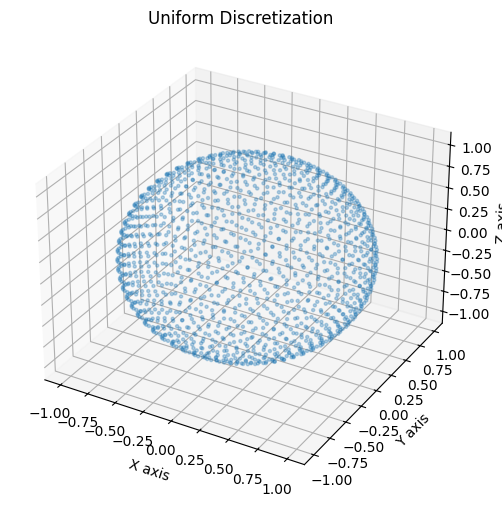

In [74]:
# Edit n_points
n_points = 1500

golden_angle = np.pi * (3 - np.sqrt(5))

x = np.zeros(n_points)
y = np.zeros(n_points)
z = np.zeros(n_points)

for i in range(n_points):
    # The ith point's z-coordinate and azimuthal angle
    z[i] = 1 - (i / float(n_points - 1)) * 2
    radius = np.sqrt(1 - z[i] * z[i])
    theta = golden_angle * i

    x[i] = radius * np.cos(theta)
    y[i] = radius * np.sin(theta)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,marker='.',alpha=0.3)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('Uniform Discretization')

plt.show()


# Icosahedron group


initial implementation, attempted method using rotation matrices (Incorrect axis chosen, should use angle/axis matrices)

In [7]:
phi = (np.sqrt(5)+1)/2
angles = [2*np.pi/3,2*np.pi/3]

#Rodrigues' rotation: specifies a rotation about a specific axis potentially faster than zyz angles
rotation_axis = np.array([1, phi, 0])
rotation_axis = rotation_axis/np.linalg.norm(rotation_axis)
x,y,z = rotation_axis
K = np.array([
    [0,-z,y],
    [z,0,-x],
    [-y,x,0]
    ])
R_3 = np.eye(3) + np.sin(angles[1])*K + (1-np.cos(angles[1]))*K**2
R_5 = np.array([
        [np.cos(angles[0]), -np.sin(angles[0]),0],
        [np.sin(angles[0]), np.cos(angles[0]),0],
        [0,0,1]
        ])
print(R_5**3)

[[-0.125      -0.64951905  0.        ]
 [ 0.64951905 -0.125       0.        ]
 [ 0.          0.          1.        ]]


In [37]:
initial_point = np.array([1,0,0])
orbit = [initial_point]
for i in range(5):
    for j in range(3):
        point = np.linalg.matrix_power(R_3,j)@np.linalg.matrix_power(R_5,i)@initial_point
        orbit.append(point)

for i in range(5):
    for j in range(3):
        point = np.linalg.matrix_power(R_5,i)@np.linalg.matrix_power(R_3,j)@initial_point
        orbit.append(point)

# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')

# # Extracting coordinates for plotting
# x, y, z = np.array(orbit).T

# # Scatter plot
# ax.scatter(x, y, z)

# # Setting labels and title
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Y Axis')
# ax.set_zlabel('Z Axis')
# ax.set_title('Icosahedral Group Orbit')

# plt.show()


NameError: name 'R_3' is not defined

# Using scipy to generate the matrix group

In this method scipy generates the matrix group. I then apply every element to the start point, a start point that does not represent a face, point or axis of rotation yields a full 60 point group

In [88]:
phi = (np.sqrt(5)+1)/2 #golden angle helps define verticies of icosahedron
icosahedral_group = R.create_group('I') #rotation group only, 60 elements
print(f'Number of rotations in icosahedral group: {len(icosahedral_group)}')
rotation_matrices = icosahedral_group.as_matrix()
d=1/3
#initial_point = (1-d)*np.array([1,phi,0])+d*np.array([0,1+2*phi,phi])
initial_point = np.array([1,1+3*phi,phi]) #This point does not lie on any axes of symmetry
second_point = np.array([1,1+phi,phi])
second_point = second_point/np.linalg.norm(second_point)
third_point = np.array([1,phi,0])
third_point = third_point/np.linalg.norm(third_point)
initial_point = initial_point/np.linalg.norm(initial_point)
orbit = []

for M in rotation_matrices: #apply every rotation to point
    new_point = M@initial_point
    orbit.append(new_point)

for M in rotation_matrices: #apply every rotation to second point
    new_point = M@second_point
    orbit.append(new_point)

for M in rotation_matrices: #apply every rotation to second point
    new_point = M@third_point
    orbit.append(new_point)

print(f'Length of orbit: {len(orbit)}')
unique_orbit = np.unique(np.array(orbit), axis=0) #check uniqueness, in case of accidentally generating a subgroup
print(f'Unique points in orbit: {np.array(unique_orbit).shape[0]}')
x, y, z = np.array(orbit).T
print(initial_point)


Number of rotations in icosahedral group: 60
Length of orbit: 180
Unique points in orbit: 166
[0.16245985 0.95105652 0.26286556]


In [89]:
print(orbit)

[array([ 0.16245985, -0.95105652, -0.26286556]), array([-0.16245985,  0.95105652, -0.26286556]), array([-0.16245985, -0.95105652,  0.26286556]), array([0.16245985, 0.95105652, 0.26286556]), array([-0.26286556, -0.16245985,  0.95105652]), array([-0.95105652, -0.26286556,  0.16245985]), array([ 0.95105652, -0.26286556, -0.16245985]), array([0.26286556, 0.16245985, 0.95105652]), array([-0.95105652,  0.26286556, -0.16245985]), array([ 0.26286556, -0.16245985, -0.95105652]), array([-0.26286556,  0.16245985, -0.95105652]), array([0.95105652, 0.26286556, 0.16245985]), array([ 0.4253254 , -0.58778525,  0.68819096]), array([-4.29552262e-17, -8.50650808e-01, -5.25731112e-01]), array([ 8.50650808e-01,  5.25731112e-01, -1.51996506e-17]), array([ 0.58778525,  0.68819096, -0.4253254 ]), array([-0.16245985, -0.95105652, -0.26286556]), array([-0.58778525, -0.68819096,  0.4253254 ]), array([-0.95105652,  0.26286556,  0.16245985]), array([-0.68819096,  0.4253254 , -0.58778525]), array([-0.26286556,  0.1

In [90]:
#3D interactive plot make sure all relevent packages are installed edit the starting points to lie on or off axes of symmetry
#middle_triangle_point = np.ndarray([0,1+2*phi,phi])
#between_centre_and_vertex = np.array([1,1+3*phi,phi])
trace = go.Scatter3d(
    x=x, 
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,
    )
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(nticks=4, range=[-1,1],),
        yaxis=dict(nticks=4, range=[-1,1],),
        zaxis=dict(nticks=4, range=[-1,1],),
        aspectratio=dict(x=1, y=1, z=1),
    )
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()
#notes: triangle: (1,phi,0), (0,1,phi), (-1,phi,0)
#reflection of triangle: [1,phi,0], [-1,phi,0], [0,1,-phi] mid = [0,1+2*phi,-phi] mid edge [0,2*phi,0] mid of mid and mid edge [0,1+4*phi,-phi]
#mid edge: (1,1+phi,phi)
#mid: (0,1+2*phi,phi)
#mid of mid edge and mid: (1,2+3*phi,2*phi)
#mid of mid and vertex: [1,1+3*phi,phi]
#scale along mid to egde: (1-d)*[1,1+phi,phi]+d*[0,1+2*phi,phi]

In [7]:

trace = go.Scatter3d(
    x=x, 
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,
    )
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(nticks=4, range=[-1,1],),
        yaxis=dict(nticks=4, range=[-1,1],),
        zaxis=dict(nticks=4, range=[-1,1],),
        aspectratio=dict(x=1, y=1, z=1),
    )
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()


# Including reflection for full icosahedron group

Unnecessary for the rotation group, includes a reflection which generates a group of 120 elements

In [8]:
xy_reflection = np.array([ #xy axis reflection
    [1,0,0],
    [0,1,0],
    [0,0,-1]
])
icosahedral_matrices = list(rotation_matrices.copy())
for M in rotation_matrices:
    icosahedral_matrices.append(M@xy_reflection)
icosahedral_matrices = np.array(icosahedral_matrices)
print(f'Icosahedral matricies shape: {icosahedral_matrices.shape}')

Icosahedral matricies shape: (120, 3, 3)


In [9]:
full_orbit = []
for M in icosahedral_matrices:
    new_point = M@initial_point
    full_orbit.append(new_point)
print(f'Length of orbit with reflection: {len(full_orbit)}')
x,y,z=np.array(full_orbit).T
unique_orbit = np.unique(np.array(full_orbit), axis=0)
print(f'Unique points in orbit: {unique_orbit.shape[0]}')

trace = go.Scatter3d(
    x=x, 
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,
    )
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(nticks=4, range=[-1,1],),
        yaxis=dict(nticks=4, range=[-1,1],),
        zaxis=dict(nticks=4, range=[-1,1],),
        aspectratio=dict(x=1, y=1, z=1),
    )
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show figure
fig.show()

Length of orbit with reflection: 120
Unique points in orbit: 120


# Images on the sphere

Initial implementation of the shape functions, full implementation is under shape_classification.ipynb

Half sphere:

In [53]:
import numpy as np

def half_sphere(p):
    # Ensure p is a numpy array for element-wise operations
    p = np.array(p)
    
    # Handle the case when p[0] is 0 to avoid division by zero
    theta = np.arctan2(p[1], p[0])  # arctan2 handles division by zero and all quadrants
    phi = np.arccos(p[2] / np.linalg.norm(p))  # Normalize p[2] to the length of p for safety

    return 1 if 0 < theta < np.pi else 0

def great_band(p):
    p = np.array(p) / np.linalg.norm(p)
    
    
    theta = np.arctan2(p[1], p[0])  # Azimuthal angle
    phi = np.arccos(p[2])  # Polar angle
    
    
    band_half_width = np.pi / 6  
    
    # Return 1 if the point is within the band, else return 0
    if (phi > (np.pi / 2 - band_half_width)) and (phi < (np.pi / 2 + band_half_width)):
        return 1
    else:
        return 0

def checkerboard(p):
    p = np.array(p) / np.linalg.norm(p)
    
    theta = np.arctan2(p[1], p[0])  # Azimuthal angle
    phi = np.arccos(p[2])  # Polar angle
    
    theta = theta % (2 * np.pi)
    
    # Define the number of divisions in each direction
    # More divisions will create a finer checkerboard pattern
    divisions_theta = 4  # Divisions in azimuthal direction
    divisions_phi = 2  # Divisions in polar direction
    
    # Calculate the width of each division
    width_theta = (2 * np.pi) / divisions_theta
    width_phi = np.pi / divisions_phi
    
    # Determine the index of the division each angle falls into
    index_theta = int(theta // width_theta)
    index_phi = int(phi // width_phi)
    
    # Return 1 if the sum of the indices is even (checkerboard pattern), else return 0
    return 1 if (index_theta + index_phi) % 2 == 0 else 0

def polar_caps(p, cap_width=np.pi/3):
    p = np.array(p) / np.linalg.norm(p)
    phi = np.arccos(p[2])  # Polar angle
    if phi < cap_width or phi > (np.pi - cap_width):
        return 1 
    return 0  




half_sphere_output = np.array([half_sphere(point) for point in orbit])
band_output = np.array([great_band(point) for point in orbit])
checkerboard_output = np.array([checkerboard(point) for point in orbit])
polar_caps_output = np.array([polar_caps(point) for point in orbit])

filtered_orbit_band = np.array(orbit)[band_output == 1]
filtered_orbit_checkerboard = np.array(orbit)[checkerboard_output == 1]
filtered_orbit_polar_caps = np.array(orbit)[polar_caps_output == 1]


In [54]:
filtered_orbit = np.array(orbit)[half_sphere_output == 1]
x,y,z=np.array(filtered_orbit_polar_caps).T
unique_orbit = np.unique(np.array(full_orbit), axis=0)
print(f'Unique points in orbit: {unique_orbit.shape[0]}')

trace = go.Scatter3d(
    x=x, 
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,
    )
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(nticks=4, range=[-1,1],),
        yaxis=dict(nticks=4, range=[-1,1],),
        zaxis=dict(nticks=4, range=[-1,1],),
        aspectratio=dict(x=1, y=1, z=1),
    )
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show figure
fig.show()

Unique points in orbit: 120
